In [1]:
!cp -r ../input/recsys-repo/RecSys_Course_AT_PoliMi-master/* ./

In [2]:
%config Completer.use_jedi = False
import pandas as pd
import numpy as np
import scipy.sparse as sps
import matplotlib.pyplot as pyplot
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample
from Evaluation.Evaluator import EvaluatorHoldout


In [3]:
URM_path = "../input/recommender-system-2021-challenge-polimi/data_train.csv"
URM_all_dataframe = pd.read_csv(filepath_or_buffer=URM_path, 
                                sep=",",
                                dtype={0:int, 1:int, 2:float},
                                header=0)
URM_all_dataframe.columns = ["UserID", "ItemID", "Interaction"]

In [4]:
URM_all_dataframe.head()

,UserID,ItemID,Interaction
0,0,53,1.0
1,0,209,1.0
2,0,223,1.0
3,0,249,1.0
4,0,435,1.0


In [5]:
print ("The number of interactions is {}".format(len(URM_all_dataframe)))

The number of interactions is 5285664


In [6]:
userID_unique = URM_all_dataframe["UserID"].unique()
itemID_unique = URM_all_dataframe["ItemID"].unique()

In [7]:
userID_unique = URM_all_dataframe["UserID"].unique()
itemID_unique = URM_all_dataframe["ItemID"].unique()

n_users = len(userID_unique)
n_items = len(itemID_unique)
n_interactions = len(URM_all_dataframe)

print ("Number of items\t {}, Number of users\t {}".format(n_items, n_users))
print ("Max ID items\t {}, Max Id users\t {}\n".format(max(itemID_unique), max(userID_unique)))
print ("Average interactions per user {:.2f}".format(n_interactions/n_users))
print ("Average interactions per item {:.2f}\n".format(n_interactions/n_items))

print ("Sparsity {:.2f} %".format((1-float(n_interactions)/(n_items*n_users))*100))

Number of items	 18059, Number of users	 13650
Max ID items	 18058, Max Id users	 13649

Average interactions per user 387.23
Average interactions per item 292.69

Sparsity 97.86 %


There isn't the problem of empty indices 

# Item popularity

In [8]:
import scipy.sparse as sps

URM_all = sps.coo_matrix((URM_all_dataframe["Interaction"].values, 
                          (URM_all_dataframe["UserID"].values, URM_all_dataframe["ItemID"].values)))

URM_all

<13650x18059 sparse matrix of type '<class 'numpy.float64'>'
	with 5285664 stored elements in COOrdinate format>

In [9]:
URM_all = sps.csr_matrix((URM_all_dataframe["Interaction"].values, 
                          (URM_all_dataframe["UserID"].values, URM_all_dataframe["ItemID"].values)),
                        shape = (n_users, n_items))

URM_all

<13650x18059 sparse matrix of type '<class 'numpy.float64'>'
	with 5285664 stored elements in Compressed Sparse Row format>

In [10]:
item_popularity = np.ediff1d(URM_all.tocsc().indptr)
item_popularity

array([ 14, 156,  49, ..., 458,  48,  98], dtype=int32)

In [11]:
item_popularity = np.sort(item_popularity)
item_popularity

array([    3,     3,     3, ..., 10109, 10118, 11199], dtype=int32)

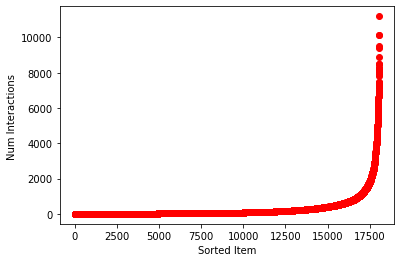

In [12]:
pyplot.plot(item_popularity, 'ro')
pyplot.ylabel('Num Interactions ')
pyplot.xlabel('Sorted Item')
pyplot.show()

In [13]:
print("Number of items with zero interactions {}".
      format(np.sum(item_popularity==0)))

Number of items with zero interactions 0


# User activity

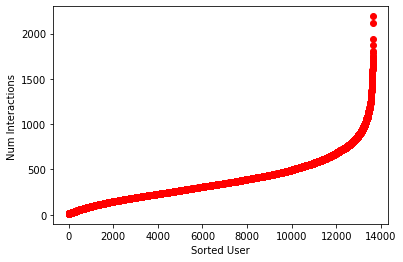

In [14]:
user_activity = np.ediff1d(URM_all.tocsr().indptr)
user_activity = np.sort(user_activity)


pyplot.plot(user_activity, 'ro')
pyplot.ylabel('Num Interactions ')
pyplot.xlabel('Sorted User')
pyplot.show()

# Split into training and validation set

In [15]:
URM_all = sps.csr_matrix((URM_all_dataframe["Interaction"].values, 
                          (URM_all_dataframe["UserID"].values, URM_all_dataframe["ItemID"].values)),
                        shape = (n_users, n_items))

URM_all

<13650x18059 sparse matrix of type '<class 'numpy.float64'>'
	with 5285664 stored elements in Compressed Sparse Row format>

In [16]:
URM_train, URM_valid = split_train_in_two_percentage_global_sample(URM_all, train_percentage = 0.80)
evaluator_validation = EvaluatorHoldout(URM_valid, cutoff_list=[10])

EvaluatorHoldout: Ignoring 13644 ( 0.0%) Users that have less than 1 test interactions


# Evaluation

In [17]:
def recall(recommendations: np.array, relevant_items: np.array) -> float:
    is_relevant = np.in1d(recommendations, relevant_items, assume_unique=True)
    
    recall_score = np.sum(is_relevant) / relevant_items.shape[0]
    
    return recall_score
    
    
def precision(recommendations: np.array, relevant_items: np.array) -> float:
    is_relevant = np.in1d(recommendations, relevant_items, assume_unique=True)
    
    precision_score = np.sum(is_relevant) / recommendations.shape[0]

    return precision_score

def MAP(recommendations: np.array, relevant_items: np.array) -> float:
    is_relevant = np.in1d(recommendations, relevant_items, assume_unique=True)
    
    precision_at_k = is_relevant * np.cumsum(is_relevant, dtype=np.float32) / (1 + np.arange(is_relevant.shape[0]))

    map_score = np.sum(precision_at_k) / np.min([relevant_items.shape[0], is_relevant.shape[0]])

    return map_score
    

Maybe it would be better to use the funcation "evaluator" from Practice 4 - Building an ItemKNN Recommender From Scratch

In [18]:
def evaluate_algorithm(URM_test, recommender_object, at=5):
    
    cumulative_precision = 0.0
    cumulative_recall = 0.0
    cumulative_MAP = 0.0
    
    num_eval = 0


    for user_id in range(URM_test.shape[0]):

        relevant_items = URM_test.indices[URM_test.indptr[user_id]:URM_test.indptr[user_id+1]]
        
        if len(relevant_items)>0:
            
            recommended_items = recommender_object.recommend(user_id, at=at)
            num_eval+=1

            cumulative_precision += precision(recommended_items, relevant_items)
            cumulative_recall += recall(recommended_items, relevant_items)
            cumulative_MAP += MAP(recommended_items, relevant_items)
            
    cumulative_precision /= num_eval
    cumulative_recall /= num_eval
    cumulative_MAP /= num_eval
    
    print("Recommender results are: Precision = {:.4f}, Recall = {:.4f}, MAP = {:.4f}".format(
        cumulative_precision, cumulative_recall, cumulative_MAP)) 

# TopPop

In [19]:
class TopPopRecommender(object):

    def fit(self, URM_train):
        
        self.URM_train = URM_train

        item_popularity = np.ediff1d(URM_all.tocsc().indptr)

        # We are not interested in sorting the popularity value,
        # but to order the items according to it
        self.popular_items = np.argsort(item_popularity)
        self.popular_items = np.flip(self.popular_items, axis = 0)
    
    
    def recommend(self, user_id, at=10, remove_seen=True):

        if remove_seen:
            seen_items = self.URM_train.indices[self.URM_train.indptr[user_id]:self.URM_train.indptr[user_id+1]]
            
            unseen_items_mask = np.in1d(self.popular_items, seen_items,
                                        assume_unique=True, invert = True)

            unseen_items = self.popular_items[unseen_items_mask]

            recommended_items = unseen_items[0:at]

        else:
            recommended_items = self.popular_items[0:at]
            

        return recommended_items

In [20]:
URM_all = URM_all.tocsr()

In [21]:
topPopRecommender = TopPopRecommender()
topPopRecommender.fit(URM_all)

for user_id in range(10):
    print(topPopRecommender.recommend(user_id, at=10))

[ 3899  8635 16365  2665 13134 15778 13914 13229  3768  1551]
[ 3473 16365 15119 14358  2665 14868   640  8207 13410  6011]
[ 6177 17330 16365 15119  5273 14181 16846 10865  2665 13134]
[ 3899  3473  6214  8635 17330 16365 15119  5273 14181 14358]
[ 6177  3473  2665 15778  1259 14868  5403  6011  6652 16791]
[ 3899  3473  6214  8635 17330 16365 15119  5273 14181 14358]
[ 6214  5273 14181 14358 16846 13134  5925 13229  3768  1551]
[ 3899  3473  8635 17330 15119  5273 14181 13134 15778  5925]
[ 8635 10865  2665 15778  3768  1259 14868  4582  5403  3200]
[ 3473  6214  8635 16365 15119 14181 16846 10865 15778  5925]


In [22]:
evaluate_algorithm(URM_valid, topPopRecommender, at=10)

Recommender results are: Precision = 0.0000, Recall = 0.0000, MAP = 0.0000


In [23]:
test_users = pd.read_csv('../input/recommender-system-2021-challenge-polimi/data_target_users_test.csv')
test_users

,user_id
0,0
1,1
2,2
3,3
4,4
...,...
13645,13645
13646,13646
13647,13647
13648,13648


In [24]:
user_id = test_users['user_id']
recommendations = []
for user in user_id:
    recommendations.append(topPopRecommender.recommend(user,at = 10))

In [25]:
for index in range(len(recommendations)):
    recommendations[index]=np.array(recommendations[index])
    
test_users['item_list']= recommendations
test_users['item_list'] = pd.DataFrame([str(line).strip('[').strip(']').replace("'","") for line in test_users['item_list']])
test_users.to_csv('submission.csv', index=False)